In [21]:
# Alina Tan
# 260894652
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns 
import random
from scipy.stats import pearsonr,spearmanr

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Load the data

In [23]:
d_icd= pd.read_csv("/content/gdrive/My Drive/COMP_565/A5/D_ICD_DIAGNOSES_DATA_TABLE.csv",converters={'ICD9_CODE': lambda x: str(x)})
mimic_3= pd.read_csv("/content/gdrive/My Drive/COMP_565/A5/MIMIC3_DIAGNOSES_ICD_subset.csv",converters={'ICD9_CODE': lambda x: str(x)})

In [24]:
d_icd

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,55,0065,Amebic brain abscess,Amebic brain abscess
1,56,0066,Amebic skin ulceration,Amebic skin ulceration
2,57,0068,Amebic infection NEC,Amebic infection of other sites
3,58,0069,Amebiasis NOS,"Amebiasis, unspecified"
4,59,0070,Balantidiasis,Balantidiasis
...,...,...,...,...
14562,10053,V1368,"Hx-cong malform-skin,ms",Personal history of (corrected) congenital mal...
14563,11201,79508,Unsat cerv cytlogy smear,Unsatisfactory cervical cytology smear
14564,11202,79509,Abn pap cervix HPV NEC,Other abnormal Papanicolaou smear of cervix an...
14565,11203,79510,Abn gland pap smr vagina,Abnormal glandular Papanicolaou smear of vagina


In [25]:
mimic_3

,SUBJECT_ID,ICD9_CODE
0,17843,2851
1,10152,0389
2,15311,4280
3,45434,5070
4,32229,51881
...,...,...
995,26042,5849
996,83875,486
997,50391,29410
998,25030,78039


Q1. LDA Gibbs sampling algorithm

In [26]:
# Create a dictionary to map ICD codes to integers
icd_dict = {}
icd_count = 0
for i, row in mimic_3.iterrows():
    if row['ICD9_CODE'] not in icd_dict:
        icd_dict[row['ICD9_CODE']] = icd_count
        icd_count += 1
        
# Map patient IDs to indices
patient_ids = mimic_3['SUBJECT_ID'].unique()
patient_id_map = {id: i for i, id in enumerate(patient_ids)}
mimic_3['PATIENT_ID_INDEX'] = mimic_3['SUBJECT_ID'].map(patient_id_map)

In [27]:
np.random.seed(123)

# Initialize variables
D = len(mimic_3['PATIENT_ID_INDEX'].unique()) #number of patients:689- num of docs
M = len(icd_dict) #number of ICDs:389- num of vocabulary
K = 5  #num of topics
alpha = 1
beta = 0.001

n_dk = np.zeros((D, K))
n_wk = np.zeros((M, K))
n_k = np.zeros(K) #topic_counts_vector K*1
z = np.zeros(len(mimic_3)) # 1000


# Initialize the topic assignments
for i, row in mimic_3.iterrows():
    patients_icd_topic_assignment=[]
    topic = np.random.randint(K)
    z[i] = topic
    d = row['PATIENT_ID_INDEX']
    w = icd_dict[row['ICD9_CODE']]
    n_dk[d, topic] += 1
    n_wk[w, topic] += 1
    n_k[topic] += 1

num_iterations = 100
# Run the Gibbs sampler
for iteration in range(num_iterations):
    for i, row in mimic_3.iterrows():
        d = row['PATIENT_ID_INDEX']
        w = icd_dict[row['ICD9_CODE']]
        topic = int(z[i])
        n_dk[d, topic] -= 1
        n_wk[w, topic] -= 1
        n_k[topic] -= 1
        
        # Calculate gamma
        gamma = (n_dk[d] + alpha) * (n_wk[w] + beta) / (n_k + M * beta)
        gamma /= np.sum(gamma)
        
        # Update topic assignment
        topic = np.random.choice(K, p=gamma) # categorical distribution
        z[i] = topic
        
        # Update count matrices
        n_dk[d, topic] += 1 # Update patients-by-topics count matrix
        n_wk[w, topic] += 1 # Update ICDs-by-topics count matrix
        n_k[topic] += 1 # Update the sufficient statistics

In [28]:
# Compute phi
phi = np.zeros((M, K)) #ICDs-by-topics matrix
for k in range(K):
    phi[:, k] = (n_wk[:, k] + beta) / (np.sum(n_wk[:, k]) + M * beta)

# Compute theta
theta = np.zeros((D, K)) #patients-by-topics matrix
for d in range(D):
    theta[d, :] = (n_dk[d, :] + alpha) / (np.sum(n_dk[d, :]) + K * alpha)


Q2.Visualizing the top ICD codes under each topic

In [29]:
phi_df=pd.DataFrame(phi)
phi_df["index"] = phi_df.index

for i, index in enumerate(icd_dict.values()):
    phi_df.loc[phi_df["index"] == index, "icd"] = list(icd_dict.keys())[i]

# Check which ICD9_CODE values in d_icd are present in phi_df["icd"]
mask = phi_df["icd"].isin(d_icd["ICD9_CODE"]) #some are missing, total 378

# Merge phi_df and d_icd on the matching ICD9_CODE values
merged_df = phi_df.loc[mask].merge(d_icd, left_on="icd", right_on="ICD9_CODE")

# Add a column with the ICD9_CODE and short title combined
merged_df["short_title"] = merged_df["icd"] + "-" + merged_df["SHORT_TITLE"]
merged_df.set_index('short_title', inplace=True)
merged_df.drop(['ROW_ID', 'index', 'ICD9_CODE', 'icd', 'SHORT_TITLE', 'LONG_TITLE'], axis=1, inplace=True)

In [30]:
new_result = pd.DataFrame()
for i in range(K):
    top_10_icds= merged_df.nlargest(10, i)
    new_result = pd.concat([new_result, top_10_icds], ignore_index=False, sort=False)

new_result.rename(columns ={0:"Topic 1",1:"Topic 2",2:"Topic 3",3:"Topic 4",4:"Topic 5"},inplace=True)


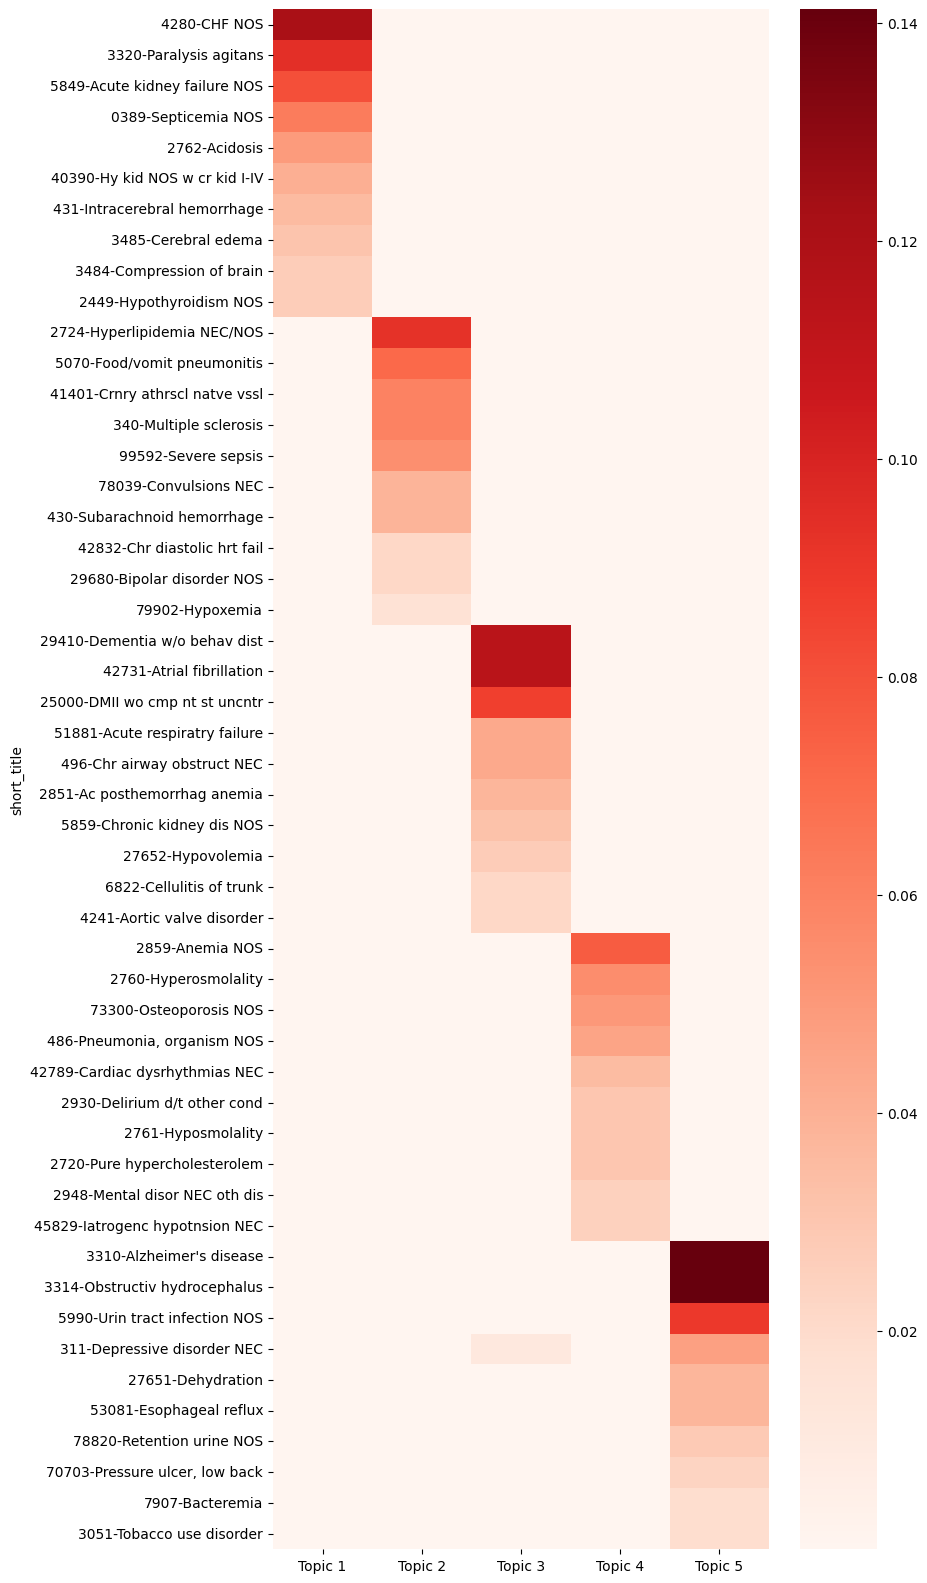

In [31]:
# Plotting the heatmap
plt.figure(figsize=(8, 20))
sns.heatmap(new_result, cmap="Reds", linecolor="white")
plt.show()

Q3. Correlating topics with the target ICD codes 

In [32]:
theta_df = pd.DataFrame(theta, index=mimic_3['SUBJECT_ID'].unique(),columns = ["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5"])
theta_df["SUBJECT_ID"] = theta_df.index
theta_sorted = theta_df.sort_values(by=["SUBJECT_ID"])

mimic_3_cp = mimic_3.copy()
mimic_3_cp["331"] = np.where(mimic_3_cp["ICD9_CODE"].str.startswith("331"), 1.0, 0.0)
mimic_3_cp["332"] = np.where(mimic_3_cp["ICD9_CODE"].str.startswith("332"), 1.0, 0.0)
mimic_3_cp["340"] = np.where(mimic_3_cp["ICD9_CODE"].str.startswith("340"), 1.0, 0.0)
mimic_3_cp2 = mimic_3_cp.copy()
add_duplciated = mimic_3_cp.groupby("SUBJECT_ID").sum(numeric_only=True)
sumed_sorted = add_duplciated.sort_values(by=["SUBJECT_ID"])
result_df = theta_df.merge(sumed_sorted, on="SUBJECT_ID")

In [33]:
# compute the correlation matrix
corr_matrix_np = np.zeros((5,3))
for i in range(5):
    for j in range(3):
        corr_matrix_np[i,j] = np.corrcoef(result_df["Topic "+str(i+1)], result_df.iloc[:,7+j])[0,1]

# create a dataframe from the correlation matrix
corr_matrix_df = pd.DataFrame(corr_matrix_np, index=["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5"], columns=["ICD 331","ICD 332","ICD 340"])

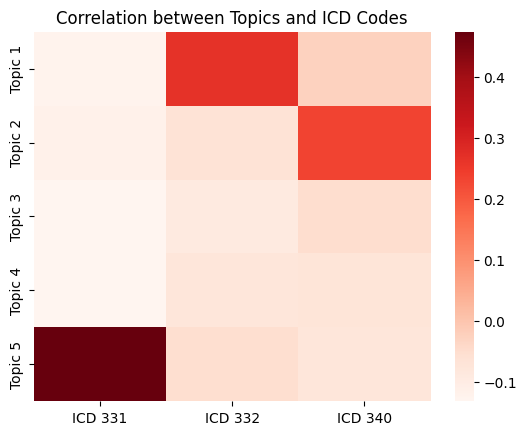

In [34]:
# Create a heatmap using seaborn
sns.heatmap(corr_matrix_df, annot=False, cmap='Reds')

# Set the title and axis labels
plt.title('Correlation between Topics and ICD Codes')
# plt.xlabel('ICD codes')
# plt.ylabel('Topics')

# Show the plot
plt.show()

Q4. Visualizing patient topic mixtures

In [35]:
#mimic_3_cp2 = mimic_3_cp.copy()
# mimic_3_cp2["331"] = np.where(mimic_3_cp2["ICD9_CODE"].str.startswith("331"), 1.0, 0.0)
# mimic_3_cp2["332"] = np.where(mimic_3_cp2["ICD9_CODE"].str.startswith("332"), 1.0, 0.0)
# mimic_3_cp2["340"] = np.where(mimic_3_cp2["ICD9_CODE"].str.startswith("340"), 1.0, 0.0)
add_duplciated_2 = mimic_3_cp2.groupby("SUBJECT_ID").sum(numeric_only=True)
sumed_with_icds = add_duplciated_2[["331", "332", "340"]]

result2 = pd.DataFrame()
for i in range(5):
    df_top100 = theta_df.nlargest(100, "Topic "+str(i+1))
    result2 = pd.concat([result2, df_top100], ignore_index=False, sort=False)


result2["SUBJECT_ID"] = result2.index
new_result2 = result2.merge(sumed_with_icds, on="SUBJECT_ID", how="left")

new_result3 = new_result2.copy()
new_result3.rename(columns={"331": "icd331", "332": "icd332","340": "icd340","1": "topic1", "2": "topic2","3": "topic3","4": "topic4","5": "topic5"}, inplace = True)

new_result3 = new_result3.drop("SUBJECT_ID", axis=1)
new_result3 =new_result3.iloc[:, [5,6,7,0,1,2,3,4]]


In [36]:
new_result3

,icd331,icd332,icd340,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,0.0,0.0,0.0,0.555556,0.111111,0.111111,0.111111,0.111111
1,0.0,0.0,0.0,0.461538,0.076923,0.230769,0.076923,0.153846
2,0.0,0.0,0.0,0.428571,0.142857,0.142857,0.142857,0.142857
3,0.0,0.0,0.0,0.428571,0.142857,0.142857,0.142857,0.142857
4,0.0,1.0,0.0,0.428571,0.142857,0.142857,0.142857,0.142857
...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.166667,0.166667,0.166667,0.166667,0.333333
496,0.0,0.0,0.0,0.166667,0.166667,0.166667,0.166667,0.333333
497,0.0,0.0,0.0,0.166667,0.166667,0.166667,0.166667,0.333333
498,1.0,0.0,0.0,0.166667,0.166667,0.166667,0.166667,0.333333


In [37]:
new_result3_icds = new_result3.iloc[:,[0,1,2]]
new_result3_topics =new_result3.iloc[:,[3,4,5,6,7]]

[]

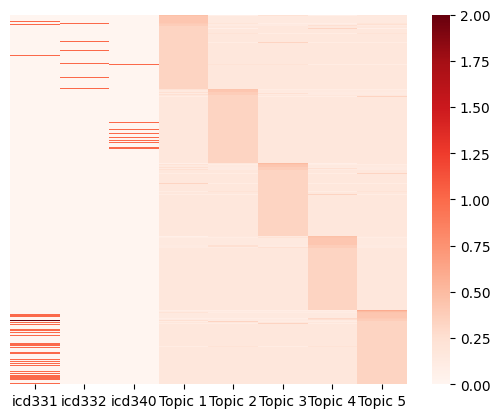

In [38]:
# Create the heatmap with white cell label background
ax = sns.heatmap(new_result3, cmap="Reds")
# Remove the y-axis tick marks
ax.set_yticks([])

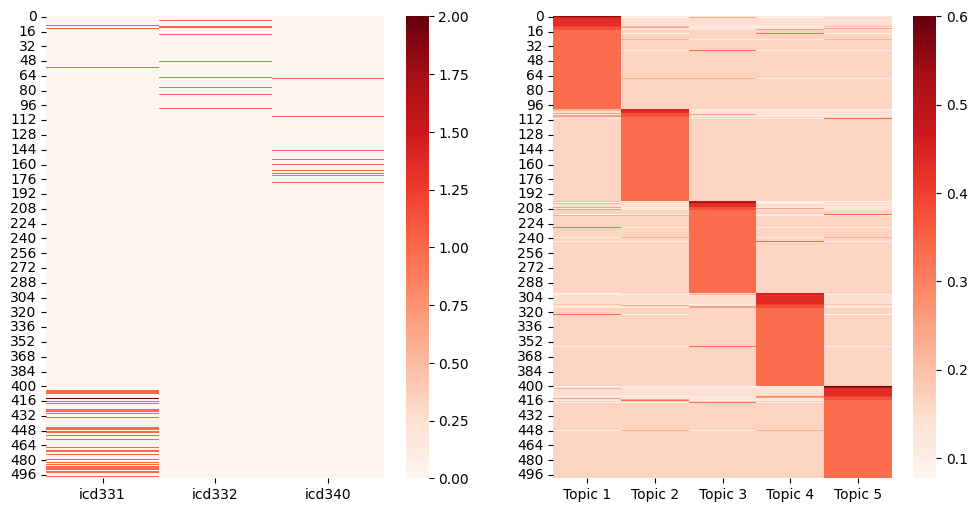

In [39]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

sns.heatmap(new_result3_icds, cmap="Reds", ax=axs[0])

sns.heatmap(new_result3_topics, cmap="Reds", ax=axs[1])

plt.show()